# Project 
 
Authors: Joseph Weibel, Rebecka Fahrni

Data: Sleep-EDF of PhysioNet

## Project Part 1: Recap 



***Project Data & Task Description***

The sleep-edf database contains 197 whole-night PolySomnoGraphic sleep recordings, containing EEG, EOG, chin EMG, and event markers. Some records also contain respiration and body temperature. Corresponding hypnograms (sleep patterns) were manually scored by well-trained technicians according to the Rechtschaffen and Kales manual. The recordings are stored in European Data Format (EDF). The goal of this project is to develop a model that can classify age (over 80 vs. under 25) or sleep stages/based on the polysomnographic recordings. The model will be trained on a subset of the Sleep-EDF database and evaluated on another subset. The performance of the model will be assessed using metrics such as accuracy, precision, recall, and F1 score.


standart positions of the electrodes:
- Fpz-Cz (EEG)
- Pz-Oz (EEG)

see: 


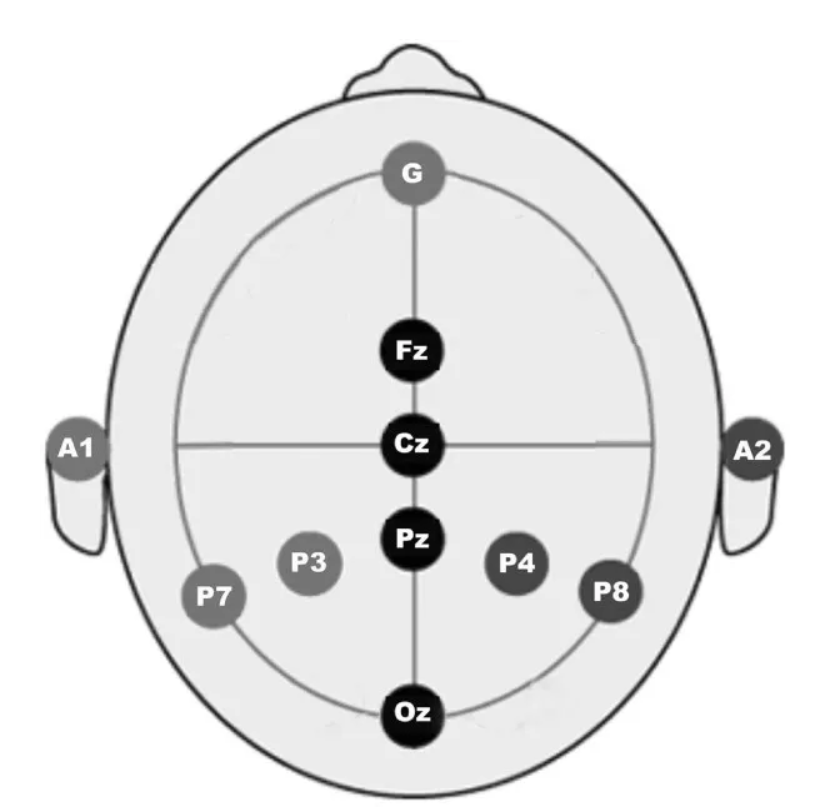

In [18]:
import mne
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import welch, spectrogram
from mne.datasets.sleep_physionet.age import fetch_data
valid_subjects = [i for i in range(83) if i not in [36, 39, 68, 52, 69, 78, 79, 13]]
# 75 subjects
recordings = [1] # only one recording per subject
mne.set_log_level('ERROR')  
fnames = fetch_data(subjects=valid_subjects, recording=recordings, on_missing='warn')



75


In [19]:
import numpy as np
import os
import mne


def loading_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30 ):
    """ Load a raw file and its annotations, crop it around sleep events"""
    
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'} 
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    
    if not load_eeg_only:
        raw.set_channel_types(mapping) 
    
    if crop_wake_mins > 0:  # crop around sleep events
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] for x in annots.description]
        sleep_event_inds = np.where(mask)[0]
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # rename eeg
    ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

def fetch_demographics(fnames):
    """ Get and parse demographic information such as age and gender. """
    participant_ages = []
    participant_gender = []
    
    for file_info in fnames:
        raw = mne.io.read_raw_edf(file_info[0], preload=True)
        subject_info = raw.info.get('subject_info', {})
        
        if 'last_name' in subject_info:  # Age is mislabeled as last_name
            age_str = subject_info['last_name']
            age = int(age_str.rstrip('yr'))
            participant_ages.append(age)
        
        if 'sex' in subject_info:
            gender = 'male' if subject_info['sex'] == 1 else 'female'
            participant_gender.append(gender)
            
    print(len(participant_ages))
        
    print(len(participant_gender))
    return participant_ages, participant_gender



75 participants found
75 participants found


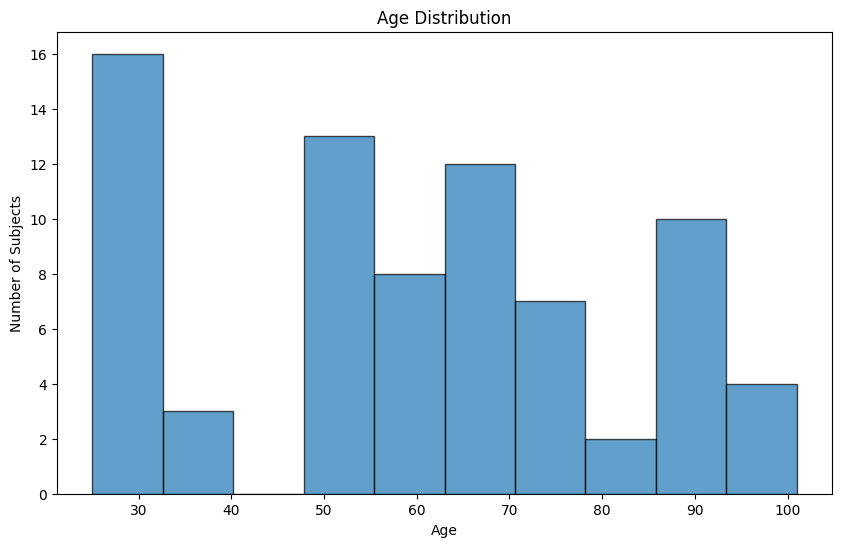

In [20]:
def plot_age_distribution(ages):
    """ Plot the age distribution of participants. """
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=10, edgecolor='black', alpha=0.7)
    plt.xlabel("Age")
    plt.ylabel("Number of Subjects")
    plt.title("Age Distribution")
    plt.show()

# Example usage
ages, genders = fetch_demographics(fnames)
plot_age_distribution(ages)




In [4]:
raws = [loading_raw(f[0], f[1]) for f in fnames] # load all files

#### preprocessing raw data
simple filtering followed by a resampling to 100 Hz. The data is then segmented into 30s epochs with 50% overlap. The data is then split into training and test sets.

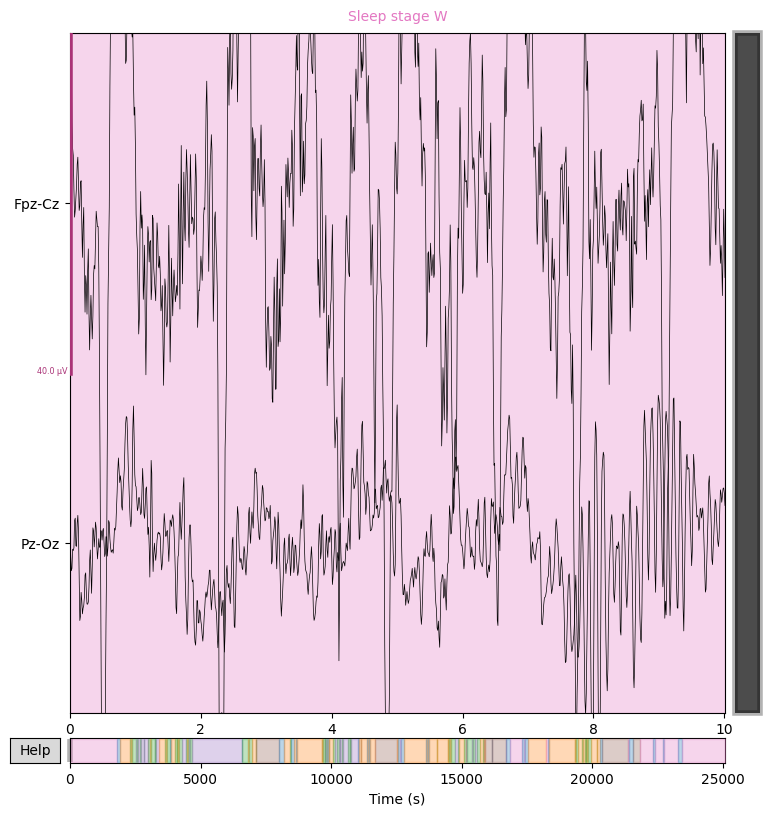

In [20]:
raws[0].plot(); # before preprocessing

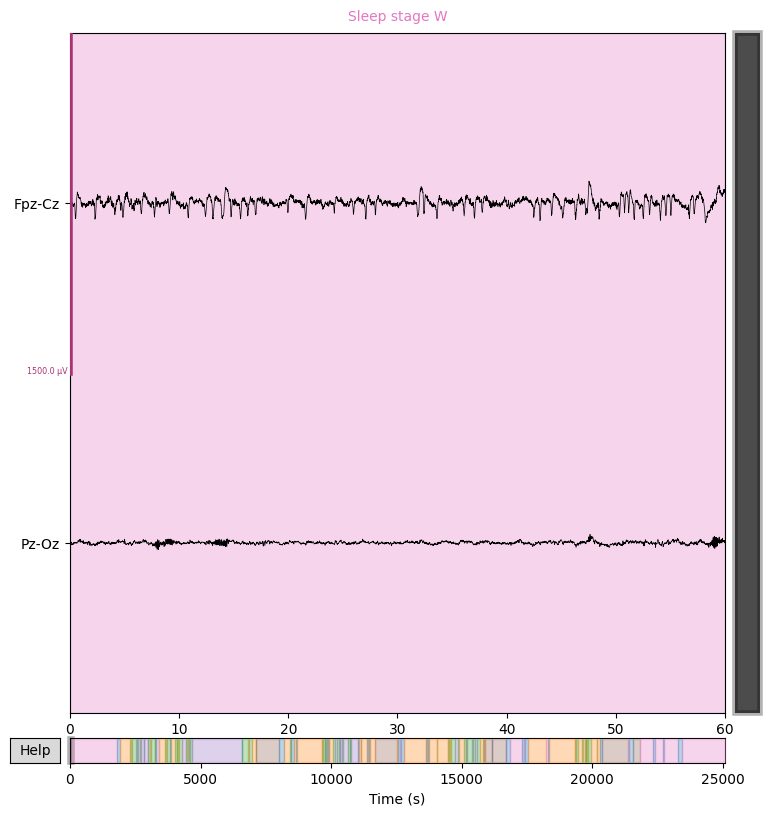

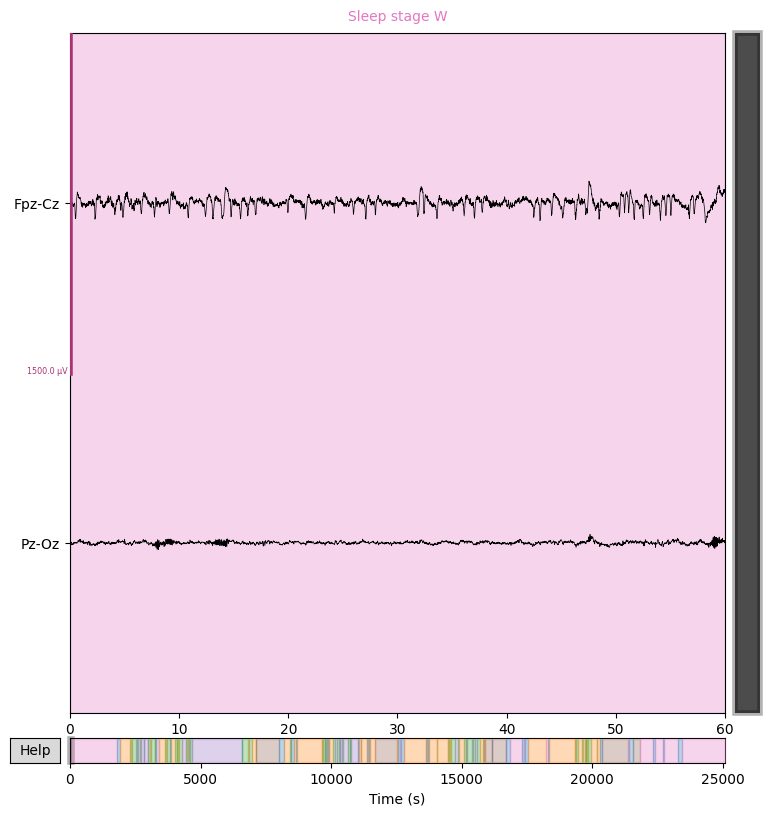

In [22]:
l_freq, h_freq = 0.3, 30

for raw in raws:
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
    
raws[0].plot(duration=60, n_channels=30, scalings={'eeg': 75e-5})


c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


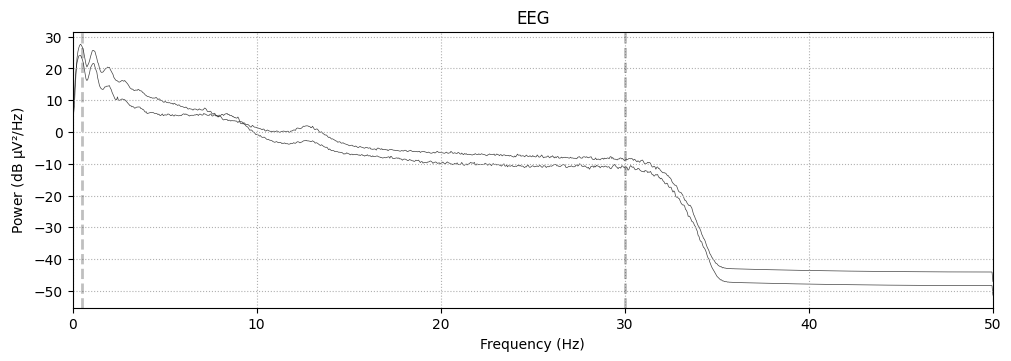

In [24]:
raws[0].plot_psd()

In [31]:
# extract epochs
def extract_epochs(raw_data):
    events, event_id = mne.events_from_annotations(raw_data, event_id={'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5})
    tmax = 30.0 - 1.0 / raw_data.info['sfreq']  # epoch duration of 30 seconds
    epochs = mne.Epochs(raw_data, events, event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    return epochs

### Feature Extraction Methods 

Each feature extraction method targets different aspects of the EEG signals. PSD is fundamental for frequency analysis, Hjorth parameters provide a quick summary of signal properties, wavelet features offer a time-frequency perspective, and entropy measures evaluate signal complexity. By combining these methods, you can build a robust feature set that captures various signal characteristics, potentially improving the accuracy of your age group classifier. When applying these methods, consider performing feature selection to identify the most predictive features for your specific classification task.

In [22]:
# hjorth parameters to get chick overview of the signal with statistical features 

def signalproperties(data): # hjorth parameters
    first_deriv = np.diff(data)
    second_deriv = np.diff(data, n=2)
    var_zero = np.var(data)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return activity, mobility, complexity

def hjorth(epochs):
    hjorth_features = []
    for epoch in epochs:
        data = epoch.get_data()
        features = [signalproperties(channel_data[0]) for channel_data in data]
        hjorth_features.append(np.mean(features, axis=0))  # Average across channels
    return np.array(hjorth_features)


#### 1. Power Spectral Density (PSD)

compute spectral density which shows strength of variations as a function of frequency - different age groups might show distinct power distribution across various frequency bands. For instance, delta waves are prominent during deep sleep and might be differentially expressed in younger versus older adults.

In [23]:
from scipy.signal import welch

def extract_psd_features(epochs):
    psd_features = []
    for epoch in epochs:
        f, Pxx = welch(epoch.get_data(), fs=epoch.info['sfreq'], nperseg=epoch.info['sfreq']*2)
        psd_features.append(Pxx.mean(axis=-1))  # Average across frequencies
    return np.array(psd_features)


#### 2. Wavelet Transform

DWT to decompose EEG signals into different frequency components. 
Provides both time and frequency information, helps identify characteristics in eeg signals that are not visible in the time or frequency domain alone and can be used to detect transient events in the signal, such as sleep spindles or K-complexes and age-related changes. 

In [27]:
import pywt

def extract_wavelet_features(epochs):
    wavelet_features = []
    for epoch in epochs:
        data = epoch.get_data()[0]  # Assuming single-channel for simplicity
        coeffs = pywt.wavedec(data, 'db4', level=5)
        features = [np.mean(np.abs(coeff)) for coeff in coeffs]
        wavelet_features.append(features)
    return np.array(wavelet_features)

#### 3. Entropy

Entropy measures the complexity of the signal. Higher entropy indicates higher complexity. Entropy can be used to quantify the complexity of EEG signals and might be differentially expressed in younger versus older adults - as brain activity changes during sleep. 

In [28]:
from scipy.stats import entropy

def calculate_entropy(data):
    hist, _ = np.histogram(data, bins='auto', density=True)
    return entropy(hist)

def extract_entropy_features(epochs):
    entropy_features = []
    for epoch in epochs:
        data = epoch.get_data()
        epoch_entropy = [calculate_entropy(channel_data[0]) for channel_data in data]
        entropy_features.append(np.mean(epoch_entropy))  # Average across channels
    return np.array(entropy_features)

In [29]:
def extract_features(raws, ages):
    feature_list = []
    metadata_list = []

    for raw in raws:
        subject_id = raw.info['subject_info']['id']
        age = ages[subject_id]
        # methods 
        epochs = extract_epochs(raw)
        hjorth_features = hjorth(epochs)
        psd_features = extract_psd_features(epochs)
        wavelet_features = extract_wavelet_features(epochs)
        entropy_features = extract_entropy_features(epochs)
        combined_features = np.concatenate([hjorth_features, psd_features, wavelet_features, entropy_features], axis=1)
        # features and metadata for each subject
        feature_list.append(combined_features)
        metadata_list.append([subject_id] * len(combined_features))
        all_features = np.vstack(feature_list)  # Stack feature arrays
        all_subject_ids = np.concatenate(metadata_list)  

    return all_features, all_subject_ids


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def extract_features(raws): 
    features = []
    for raw in raws:
        # get id of the subject
        subject_id = raw.info['subject_info']['id']
        # get age of the subject
        age = ages[subject_id]
        epochs = extract_epochs(raw)
        hjorth_features = hjorth(epochs)
        psd_features = extract_psd_features(epochs)
        wavelet_features = extract_wavelet_features(epochs)
        entropy_features = extract_entropy_features(epochs)
        combined_features = np.concatenate([hjorth_features, psd_features, wavelet_features, entropy_features], axis=1)
        features.append(combined_features)
    # return dataframe with features (headers per method), subject id and age
    
    return np.concatenate(features, axis=0)
    #return np.concatenate(features, axis=0)

# create dictionary to store features and their age/gender and subject id

features = extract_features(raws)
features_dict = {'features': features }
features_df = pd.DataFrame(features_dict)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_df = pd.DataFrame(features_scaled, columns=[f"feature_{i}" for i in range(features_scaled.shape[1])])


NameError: name 'extract_epochs' is not defined

### Feature Selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

def select_features_rfe(X_train, y_train):
    estimator = SVC(kernel="linear")
    selector = RFECV(estimator, step=1, cv=5)
    selector = selector.fit(X_train, y_train)
    return X_train.columns[selector.support_], selector


In [8]:
import pandas as pd
# extract features method 1
def extract_features(epochs):
    freq_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30)}
    features = []
    for epoch in epochs:
        psd, freqs = mne.time_frequency.psd_welch(epoch, fmin=0.5, fmax=30., n_fft=256) 
        feature = {band: psd[:, (freqs >= band_range[0]) & (freqs < band_range[1])].mean() for band, band_range in freq_bands.items()}
        features.append(feature)
    return pd.DataFrame(features)

In [27]:
# extract features 

def extract_features(raw, nperseg=256, noverlap=128, window='hamming'):
    data = raw.get_data()
    freqs, psd = welch(data, fs=raw.info['sfreq'], 
                       nperseg=nperseg, noverlap=noverlap)
    return freqs, psd

def apply_pca(features, n_components=5):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features)
    return pca, pca_features

def plot_frequencty_psd(freqs, psd, title):
    plt.figure()
    plt.plot(freqs, psd)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.show()
    

def plot_pca_components(pca_features):
    plt.figure(figsize=(10, 6))
    for i in range(pca_features.shape[1]):
        plt.plot(pca_features[:, i], label=f'Component {i+1}')
    plt.legend()
    plt.title('PCA Components')
    plt.show()

# Main function to orchestrate the feature extraction and plotting

for raw in raws:
    freqs, psd = extract_features(raw)
    pca_features, pca = apply_pca(psd)
    plot_frequencty_psd(freqs, psd, 'PSD')
    plot_pca_components(pca_features)
    plot_frequencty_psd(freqs, pca.components_[0], 'PCA Component 1')
    plot_frequencty_psd(freqs, pca.components_[1], 'PCA Component 2')
    plot_frequencty_psd(freqs, pca.components_[2], 'PCA Component 3')
    plot_frequencty_psd(freqs, pca.components_[3], 'PCA Component 4')
    plot_frequencty_psd(freqs, pca.components_[4], 'PCA Component 5')
    



NameError: name 'welch' is not defined

In [ ]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

from psd we see that filter has cut off most of the power above 30 Hz.


## Project Part 2

### Feature Selection


***Feature Extraction***

The first step in the feature extraction process is to load the data and extract the hypnogram. The hypnogram is a sequence of sleep stages that correspond to the polysomnographic recordings. The sleep stages are scored as follows:

- Wake (W)
- Stage 1 (N1)
- Stage 2 (N2)
- Stage 3 (N3)
- Stage 4 (N4)
- REM (R)






### 1. Preprocessing



### 2. Feature Extraction

spectral features, time domain features, and statistical features.

Spectral features:
- Power spectral density (PSD)

spectral features for different frequency bands (delta, theta, alpha, beta, gamma) or in case of sleep-edf data, the power spectral density (PSD) for each epoch of the polysomnographic recordings. 

component analysis (PCA) to reduce the dimensionality of the feature space - after applying pca/ica to the spectral features, we can use the first n components as features for the model.

plot selected feature with distribution and relevance 



### 3. Feature Selection